In [1]:
import os

os.chdir("../../")

import statsmodels.tsa.api as smt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

In [2]:
ts_data = ingestion.read_combined().dropna()

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Train and test set

In [3]:
X = ts_data.drop(columns=["consumption", "temperature"])
y = ts_data["consumption"]

X_train = X[:"2020"]
X_test = X["2021":]
y_train = y[:"2020"]
y_test = y["2021":]

# AutoReg with lag 1 and external regressors
model = smt.AutoReg(y_train, lags=1, exog=X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            consumption   No. Observations:                 1553
Model:                   AutoReg-X(1)   Log Likelihood              -20451.051
Method:               Conditional MLE   S.D. of innovations         127808.111
Date:                Wed, 22 Mar 2023   AIC                          40922.103
Time:                        16:17:35   BIC                          40975.576
Sample:                    10-02-2016   HQIC                         40941.989
                         - 12-31-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.964e+06   4.24e+04     46.354      0.000    1.88e+06    2.05e+06
consumption.L1         0.5191      0.009     57.897      0.000       0.502       0.537
temperature_capped -7.992e+04   1500.546    -53.264      0.000   -8.29e+04    -7.7e+04
imbalance_prices    -920.6210    473.547     -1.944      0.052   -1848.757       7.515
electricity_price   3502.2588    278.510     12.575      0.000    2956.389    4048.129
crude_oil_price     -306.4644    301.961     -1.015      0.310    -898.297     285.368
eua_price           1537.0391    419.695      3.662      0.000     714.453    2359.626
storage_levels       214.7605     62.692      3.426      0.001      91.886     337.635
weekend            -2.105e+05   7815.592    -26.938      0.000   -2.26e+05   -1.95e+05
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9265           +0.0000j            1.9265            0.0000
-----------------------------------------------------------------------------
"""

(0.0, 7000000.0)

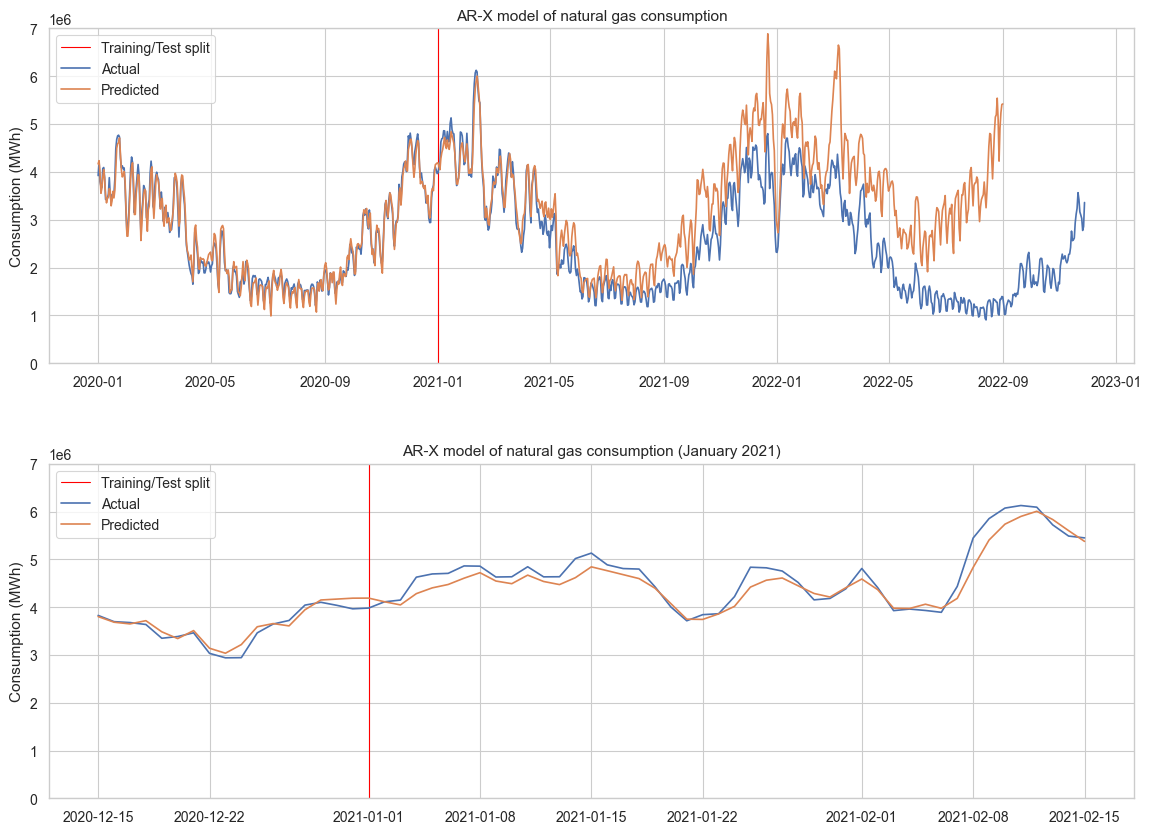

In [21]:
# Plot linear regression
regression_y = model.predict(results.params, start=0, end="2022-09", exog=X_train, exog_oos=X_test)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Enough vertical space
fig.subplots_adjust(hspace=0.3)

ax1.axvline(pd.Timestamp("2021-01-01"), color="red", linewidth=0.8, label="Training/Test split")
ax1.plot(y["2020":], label="Actual")
ax1.plot(regression_y["2020":], label="Predicted")
ax1.set_ylabel("Consumption (MWh)")
ax1.legend()
ax1.set_title("AR-X model of natural gas consumption")
ax1.set_ylim(0, 7*10**6)

ax2.axvline(pd.Timestamp("2021-01-01"), color="red", linewidth=0.8, label="Training/Test split")
ax2.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax2.plot(regression_y["2020-12-15":"2021-02-15"], label="Predicted")
ax2.set_ylabel("Consumption (MWh)")
ax2.legend()
ax2.set_title("AR-X model of natural gas consumption (January 2021)")
ax2.set_ylim(0, 7*10**6)